# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

In [ ]:
import os
from pathlib import Path
import sys


NOTEBOOK_NAME = "C1_M5_Assignment_transferlearning.ipynb" #TODO: automate this
REPO_URL = "https://github.com/SDAIA-Bootcamps/ai-pros-v1-2025.git"

if 'google.colab' in sys.modules:
    print('in colab')
    if os.system('git config --get remote.origin.url') != REPO_URL:
        print('cloning...')
        !git clone $REPO_URL
        repo_dir = REPO_URL.split('/').pop().strip('.git')
        print(f'{repo_dir=}')
        labdir = next(Path(repo_dir).rglob(NOTEBOOK_NAME)).parent.absolute()
        print(f'{labdir=}')
        %cd $labdir

    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

# allow "hot-reloading" of modules
# %load_ext autoreload
# %autoreload 2
# needed for inline plots in some contexts
%matplotlib inline


!pwd
%ls

in colab
cloning...
Cloning into 'ai-pros-v1-2025'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 258 (delta 52), reused 33 (delta 33), pack-reused 185 (from 1)
Receiving objects: 100% (258/258), 28.98 MiB | 28.37 MiB/s, done.
Resolving deltas: 100% (64/64), done.
repo_dir='ai-pros-v1-2025'
labdir=PosixPath('/content/ai-pros-v1-2025/W4_DL/C1_M5_TransferLearning/ai-pros-v1-2025/W4_DL/C1_M5_TransferLearning')
/content/ai-pros-v1-2025/W4_DL/C1_M5_TransferLearning/ai-pros-v1-2025/W4_DL/C1_M5_TransferLearning
/content/ai-pros-v1-2025/W4_DL/C1_M5_TransferLearning/ai-pros-v1-2025/W4_DL/C1_M5_TransferLearning
C1_M5_Assignment_transferlearning.ipynb  helper_utils.py


## Imports

In [ ]:
# YOUR CODE HERE
# YOUR CODE HERE
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# YOUR CODE HERE
import zipfile
import os


zip_path = '/content/drive/MyDrive/archive (7).zip'
extract_path = '/content/weather_dataset'

# Extracting the dataset
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Successfully extracted to {extract_path}")
else:
    print("Error: Zip file not found on Google Drive. Check the file path.")

Successfully extracted to /content/weather_dataset


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [ ]:
# YOUR CODE HERE

from torchvision import datasets
from torch.utils.data import random_split


data_dir = '/content/weather_dataset/dataset'
full_dataset = datasets.ImageFolder(root=data_dir)


print(f"Correct Classes: {full_dataset.classes}")

# Define the split sizes (e.g., 80% for training, 20% for testing)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Dataset Split Complete:")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Correct Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Dataset Split Complete:
Train samples: 5489
Test samples: 1373


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [ ]:
# YOUR CODE HERE

from collections import Counter

# 1. Get total counts from the full dataset
full_counts = Counter([label for _, label in full_dataset.samples])
class_names = full_dataset.classes

print(" Original Kaggle Source Counts ")
for idx, name in enumerate(class_names):
    print(f"{name}: {full_counts[idx]}")

print(f"\nTotal Images: {sum(full_counts.values())}")

# 2. Verify  Train/Test split counts
print("\n Your Local Split Counts ")
print(f"Train Set Size: {len(train_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")

# Check if the sum matches the source
if len(train_dataset) + len(test_dataset) == sum(full_counts.values()):
    print("\n Verification Successful: Your total count matches Kaggle (1,125).")
else:
    print("\n Warning: Count mismatch. Please check your data directory.")

 Original Kaggle Source Counts 
dew: 698
fogsmog: 851
frost: 475
glaze: 639
hail: 591
lightning: 377
rain: 526
rainbow: 232
rime: 1160
sandstorm: 692
snow: 621

Total Images: 6862

 Your Local Split Counts 
Train Set Size: 5489
Test Set Size: 1373

 Verification Successful: Your total count matches Kaggle (1,125).


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
# YOUR CODE HERE
from torchvision import transforms
from torch.utils.data import DataLoader

# Create transformation pipelines


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Apply transforms to existing datasets

train_dataset.dataset.transform = data_transforms['train']
test_dataset.dataset.transform = data_transforms['val']


In [ ]:
# YOUR CODE HERE

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Quick Check**: Visualize a batch of training images

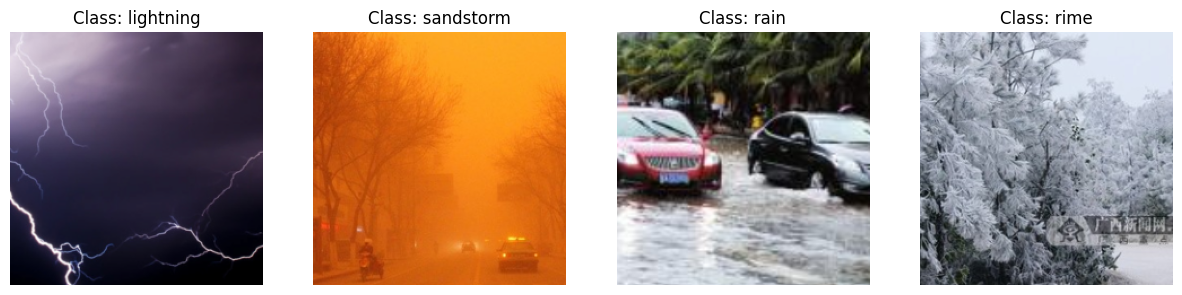

In [ ]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import numpy as np

#get one batch of image,lable from data loader
images, labels = next(iter(train_loader))

# reverse the normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# display 4 image
plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    # Convert tensor to numpy
    img = images[i].numpy().transpose((1, 2, 0))

  # Denormalize: multiply by std and add the mean to restore original colors
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(f"Class: {full_dataset.classes[labels[i]]}")
    plt.axis('off')

plt.show()

<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [ ]:
# YOUR CODE HERE
import torch.nn as nn
from torchvision import models

# 1. Load pre-trained ResNet-18 model
model = models.resnet18(weights='IMAGENET1K_V1')

# 2. Freeze pre-trained layers (Transfer Learning)
for param in model.parameters():
    param.requires_grad = False

# 3. Modify the final fully connected layer for 11 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11) # Set to 11 classes

# 4. Move model to GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model successfully adapted for {len(full_dataset.classes)} classes.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


Model successfully adapted for 11 classes.


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [75]:
import time
import copy
import torch

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)


    return model, history

In [ ]:
# 1: Feature Extraction
# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Strategy 1: Only optimize the parameters of the final layer (the head)
optimizer_ft_head = torch.optim.Adam(model.fc.parameters(), lr=0.001)

print("Starting Strategy 1: Feature Extraction (Training only the head)...")
model = train_model(model, criterion, optimizer_ft_head, num_epochs=5)

Starting Strategy 1: Feature Extraction (Training only the head)...
Epoch 0/4
----------
train Loss: 1.1222 Acc: 0.6613
val Loss: 0.6884 Acc: 0.7946

Epoch 1/4
----------
train Loss: 0.5936 Acc: 0.8216
val Loss: 0.5398 Acc: 0.8186

Epoch 2/4
----------
train Loss: 0.4908 Acc: 0.8495
val Loss: 0.4843 Acc: 0.8354

Epoch 3/4
----------
train Loss: 0.4334 Acc: 0.8617
val Loss: 0.4632 Acc: 0.8420

Epoch 4/4
----------
train Loss: 0.4118 Acc: 0.8701
val Loss: 0.4414 Acc: 0.8543

Training complete in 4m 30s
Best val Acc: 0.854334


In [ ]:
# Unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

# Strategy 2: Optimize the whole model with a much smaller learning rate
optimizer_finetune = torch.optim.Adam(model.parameters(), lr=0.0001)

print("Starting Strategy 2: Fine-Tuning (Training the entire network)...")
model = train_model(model, criterion, optimizer_finetune, num_epochs=5)

Starting Strategy 2: Fine-Tuning (Training the entire network)...
Epoch 0/4
----------
train Loss: 0.3589 Acc: 0.8809
val Loss: 0.3402 Acc: 0.8820

Epoch 1/4
----------
train Loss: 0.1068 Acc: 0.9672
val Loss: 0.3297 Acc: 0.8980

Epoch 2/4
----------
train Loss: 0.0429 Acc: 0.9885
val Loss: 0.2876 Acc: 0.9075

Epoch 3/4
----------
train Loss: 0.0298 Acc: 0.9922
val Loss: 0.3120 Acc: 0.9119

Epoch 4/4
----------
train Loss: 0.0160 Acc: 0.9960
val Loss: 0.3416 Acc: 0.9082

Training complete in 5m 6s
Best val Acc: 0.911872


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [ ]:
#  Load a fresh pre-trained model
model = models.resnet18(weights='IMAGENET1K_V1')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model.to(device)

In [ ]:
# 2. Freeze pre-trained layers (Transfer Learning)
for param in model.parameters():
    param.requires_grad = False

# 3. Modify the final fully connected layer for 11 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11)
model_conv = model_conv.to(device)

In [ ]:
# YOUR CODE HERE
# 4. Set up the optimizer to only train the final layer (the head)

optimizer_conv = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Define the loss function (Criterion)
criterion = nn.CrossEntropyLoss()

print("Optimizer and Loss function are ready.")

Optimizer and Loss function are ready.


In [76]:
# YOUR CODE HERE
# 5. Train the model using the Fixed Feature Extractor strategy
#  train for 5 epochs as a start
print("Starting Training (Fixed Feature Extractor Strategy)...")

trained_model,history_conv = train_model(
    model_conv,
    criterion,
    optimizer_conv,
    num_epochs=5
)

Starting Training (Fixed Feature Extractor Strategy)...
Epoch 0/4
----------
train Loss: 0.2756 Acc: 0.9060
val Loss: 0.4205 Acc: 0.8580

Epoch 1/4
----------
train Loss: 0.2639 Acc: 0.9109
val Loss: 0.4217 Acc: 0.8594

Epoch 2/4
----------
train Loss: 0.2672 Acc: 0.9065
val Loss: 0.4286 Acc: 0.8529

Epoch 3/4
----------
train Loss: 0.2727 Acc: 0.9018
val Loss: 0.4212 Acc: 0.8602

Epoch 4/4
----------
train Loss: 0.2595 Acc: 0.9098
val Loss: 0.4153 Acc: 0.8660

Training complete in 4m 48s
Best val Acc: 0.865987


**Quick Check**: Visualize training history

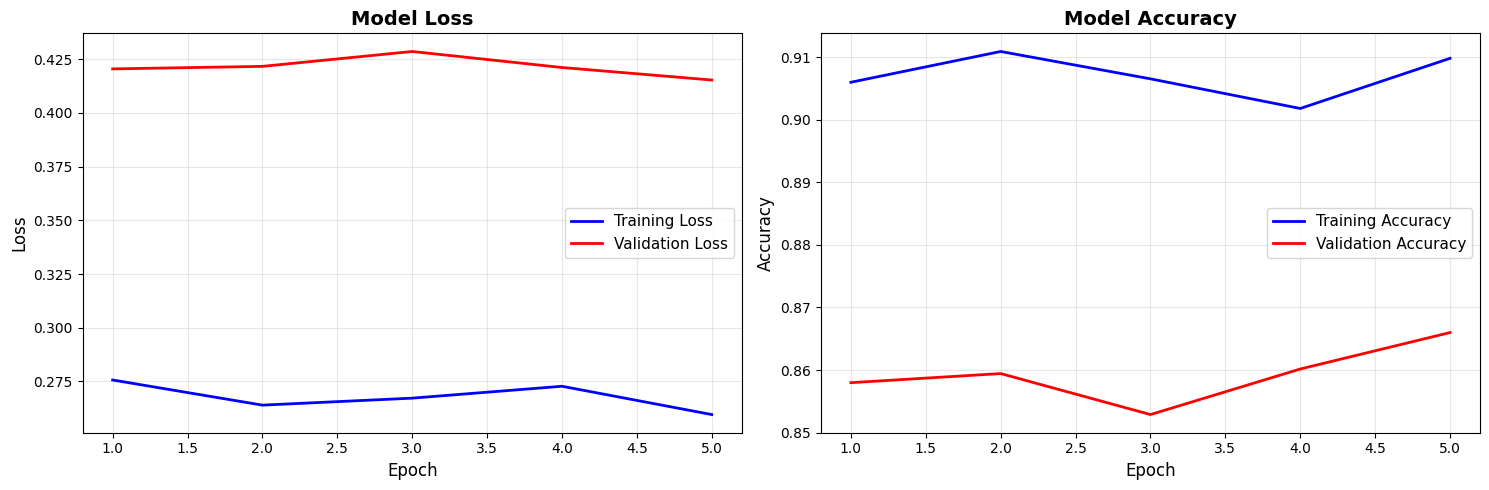

In [77]:
import helper_utils
helper_utils.visualize_training_history(history_conv)
plt.show()


**Quick Check**: Visualize predictions

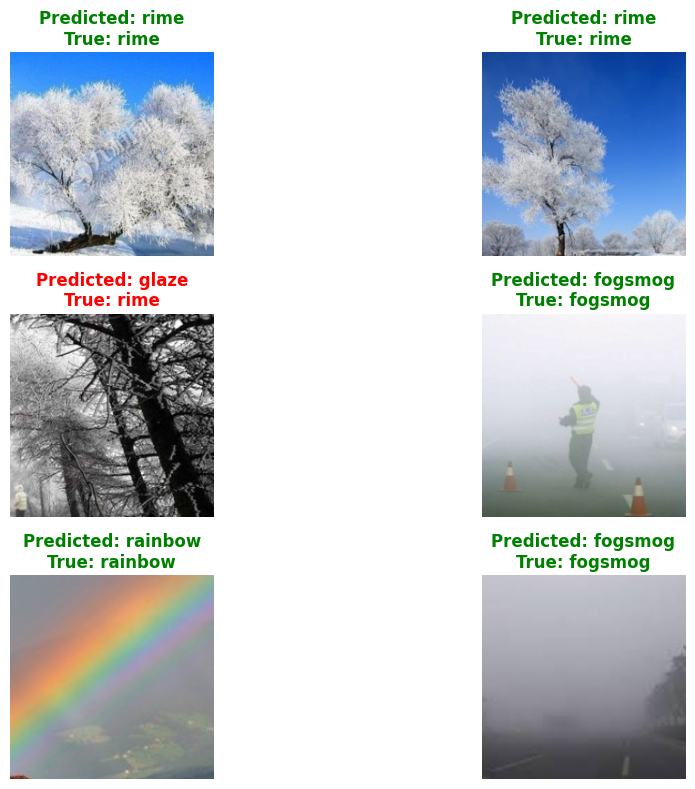

In [78]:
# helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=6)
# plt.show()
helper_utils.visualize_predictions(
    model_conv,
    test_loader,
    class_names,
    device,
    num_images=6
)
plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [79]:
# YOUR CODE HERE
from torchvision import models
import torch.nn as nn

# 1. Load a fresh pre-trained model
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Move to device
model_ft = model_ft.to(device)

In [80]:
# YOUR CODE HERE
# 2. Modify the final layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)

# Ensure the new layer is on the correct device
model_ft.fc = model_ft.fc.to(device)

In [81]:
# YOUR CODE HERE
import torch.optim as optim

# 3. Set up optimizer for all parameters with a smaller learning rate
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Loss function
criterion = nn.CrossEntropyLoss()

In [82]:
# YOUR CODE HERE
# 4. Train the model
print("Starting Strategy 2: Fine-tuning (Entire Network)")

model_ft, history_ft = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    num_epochs=5
)

Starting Strategy 2: Fine-tuning (Entire Network)
Epoch 0/4
----------
train Loss: 0.5834 Acc: 0.8185
val Loss: 0.2953 Acc: 0.9075

Epoch 1/4
----------
train Loss: 0.1765 Acc: 0.9463
val Loss: 0.2858 Acc: 0.9097

Epoch 2/4
----------
train Loss: 0.0829 Acc: 0.9774
val Loss: 0.3452 Acc: 0.9002

Epoch 3/4
----------
train Loss: 0.0557 Acc: 0.9858
val Loss: 0.3278 Acc: 0.9046

Epoch 4/4
----------
train Loss: 0.0251 Acc: 0.9944
val Loss: 0.3093 Acc: 0.9155

Training complete in 5m 5s
Best val Acc: 0.915513


**Quick Check**: Visualize training history

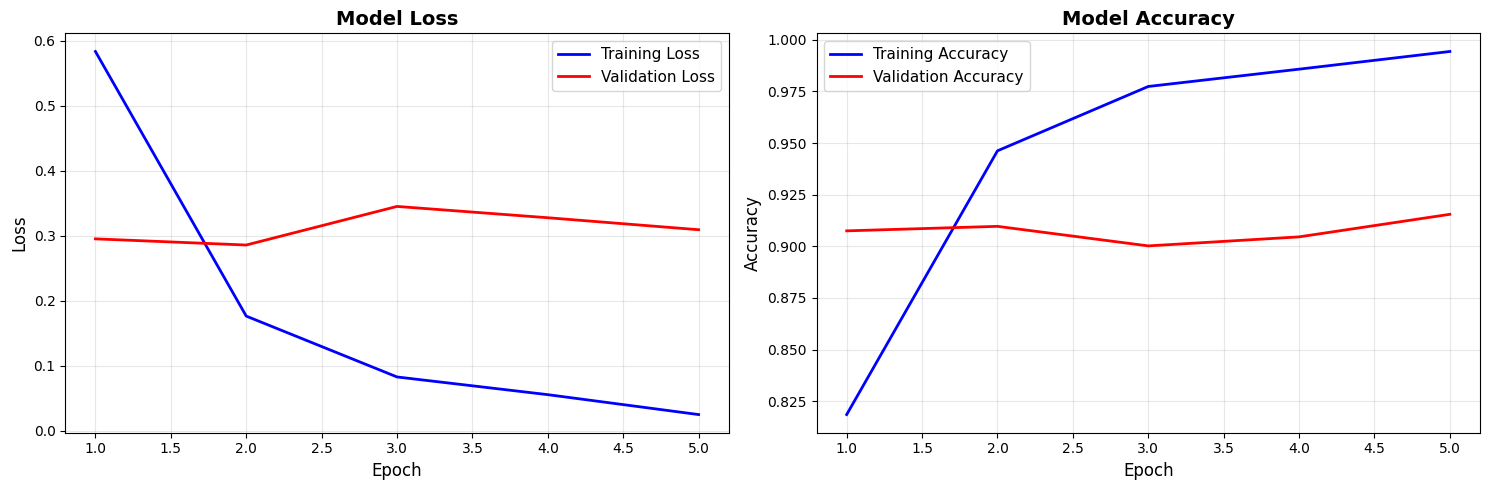

In [83]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

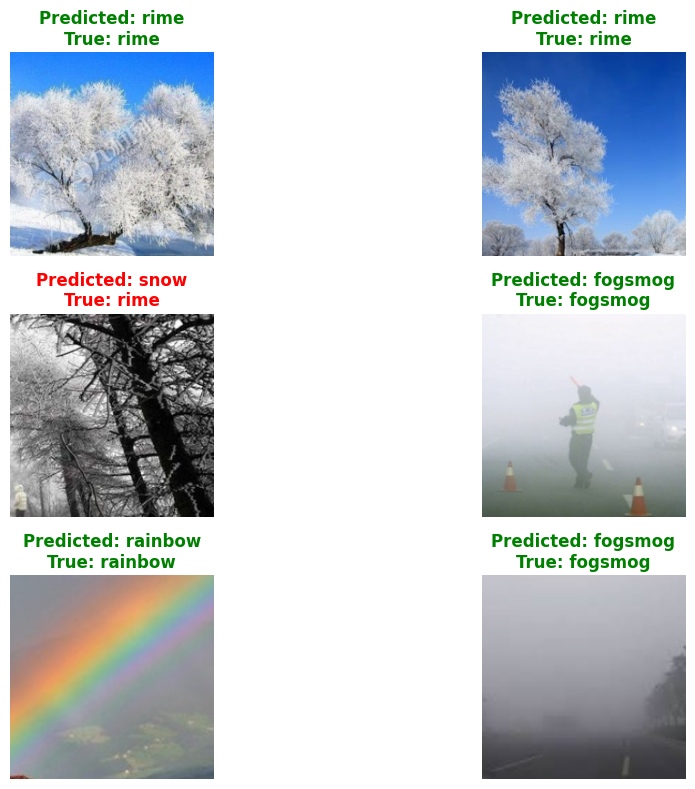

In [84]:
helper_utils.visualize_predictions(model_ft, test_loader, class_names, device, num_images=6)
plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [85]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
print("Feature Extractor Approach:")
print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
print()
print("Fine-tuning Approach:")
print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

Feature Extractor Approach:
  Best Val Accuracy: 0.8660
  Final Val Accuracy: 0.8660

Fine-tuning Approach:
  Best Val Accuracy: 0.9155
  Final Val Accuracy: 0.9155


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

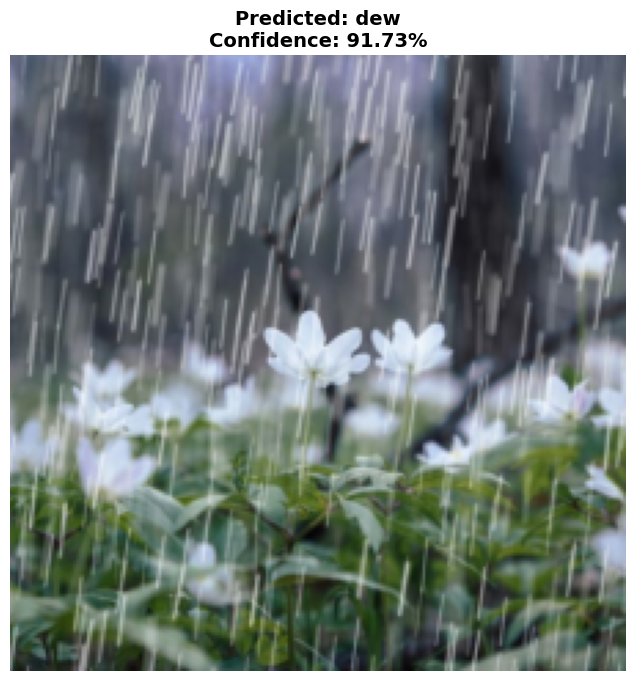

In [88]:
# Make prediction on a custom image
img_path = '/content/rain.jpg'

# YOUR CODE HERE
# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
helper_utils.visualize_single_prediction(
     model_ft,  # or model_conv
     img_path,
    data_transforms['val'],
    class_names,
     device
 )
plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [ ]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")

In [ ]:
# Load ONNX model and perform inference
# YOUR CODE HERE

# Load ONNX model
# ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
# img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
# img_tensor = data_transforms['val'](img).unsqueeze(0)
# img_numpy = img_tensor.numpy()

# Run inference
# outputs = ort_session.run(None, {'input': img_numpy})
# predictions = np.array(outputs[0])
# pred_class_idx = np.argmax(predictions[0])
# pred_class = class_names[pred_class_idx]
# confidence = np.max(predictions[0])

# print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")